See 'swallow classification bandpass.ipynb' for preprocessing.

In [1]:
import os
import pandas as pd
import random
import shutil

data_path = r'C:\Users\chloe\OneDrive\Desktop\swallow EMG\data\07_18_25\extracted signals'
class_folders = os.listdir(data_path)

# Feature Extraction
I got some of these features and functions from this link: https://www.kaggle.com/code/calulamabel/emg-hand-gesture-classification/notebook

In [2]:
import numpy as np

# mean absolute value
def mav(data):
    return np.mean(np.abs(data), axis=0)

# root mean square
def rms(data):
    return np.sqrt(np.mean(data**2,axis=0))  
    
# wavelength
def wavelength(data):
    return np.sum(np.abs(np.diff(data)), axis=0)
    
# zero crossing rate
def zcr(data):
    return np.sum(np.diff(np.sign(data), axis=0) != 0, axis=0) / (len(data)-1)

# variance
def var(data):
    return np.var(data, axis=0)

# sum of absolute differences between consecutive samples
def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)

# mean frequency
def mean_freq(data, fs=500):
    freqs = np.fft.rfftfreq(len(data), d=1/fs)
    spectrum = np.abs(np.fft.rfft(data))**2
    return np.sum(freqs * spectrum) / np.sum(spectrum)

# median frequency
def median_freq(data, fs=500):
    freqs = np.fft.rfftfreq(len(data), d=1/fs)
    spectrum = np.abs(np.fft.rfft(data))**2
    cumulative = np.cumsum(spectrum)
    total = cumulative[-1]
    med_idx = np.searchsorted(cumulative, total / 2)
    return freqs[med_idx]

# peak frequency
def peak_freq(data, fs=500):
    freqs = np.fft.rfftfreq(len(data), d=1/fs)
    spectrum = np.abs(np.fft.rfft(data))**2
    peak_idx = np.argmax(spectrum)
    return freqs[peak_idx]

In [3]:
df = pd.DataFrame()

class_map = {}
i = 0

for class_name in os.listdir(data_path):
    if class_name == 'oral prep 0':
        continue
        
    class_path = os.path.join(data_path, class_name)
    class_str = class_name.rstrip('.txt')
    parts = class_str.split()
    volume = parts[-1]
    substance = ' '.join(parts[:-1])
    
    for sample_name in os.listdir(class_path):
        sample_df = pd.read_csv(os.path.join(data_path, class_name, sample_name), delimiter = ",", header = None)
        
        sample_df.columns = [f"channel {i+1}" for i in range(sample_df.shape[1])]
        if substance not in class_map:
            class_map[substance] = i
            i += 1
        
        sample_df['substance'] = substance
        sample_df['volume'] = volume
        sample_df_grouped = sample_df.groupby(['substance', 'volume'])
        
        features_df = sample_df_grouped.agg(['max', mav, rms, wavelength, zcr, var, abs_diffs_signal, mean_freq, median_freq, peak_freq])
        df = pd.concat([df, features_df])

df.reset_index(inplace=True)
df

substance volume channel 1                                                \
                           max        mav        rms    wavelength       zcr   
0       apple     10   73.5244  10.123081  15.526914   8511.370464  0.271271   
1       apple     10   86.1073   9.896790  16.791919   8262.519721  0.290290   
2       apple     10   84.7438  10.532140  16.572327   8938.223938  0.274274   
3       apple     10  125.6940  11.846242  20.842131   9634.231501  0.250250   
4       apple     10   84.5021  11.854229  18.994828   9543.440074  0.257257   
..        ...    ...       ...        ...        ...           ...       ...   
318    yogurt     20   69.5755  10.175371  15.426147   8874.451929  0.279279   
319    yogurt     20   74.0248  11.288252  18.020237   9792.563997  0.273273   
320    yogurt     20   91.9620  11.081596  17.163182   8838.968969  0.254254   
321    yogurt     20   61.4933  11.031382  16.758005   9634.328738  0.288288   
322    yogurt     20   91.9919  13.782139  20.737838  11234.928474  0.265265   

                                             ... channel 22           \
            var abs_diffs_signal  mean_freq  ...        max      mav   
0    241.085047      8511.370464  67.493364  ...      14560  3322.06   
1    281.968302      8262.519721  64.960675  ...      12040  4038.86   
2    274.641479      8938.223938  69.765386  ...      14560  4577.86   
3    434.394440      9634.231501  62.981642  ...      22260  5437.88   
4    360.801618      9543.440074  63.408721  ...      15400  5531.54   
..          ...              ...        ...  ...        ...      ...   
318  237.965865      8874.451929  69.720942  ...      18760  3136.98   
319  324.728936      9792.563997  70.751609  ...      11200  3865.40   
320  294.572930      8838.968969  64.957040  ...      13580  4293.94   
321  280.830702      9634.328738  68.141730  ...      12040  3813.46   
322  430.057924     11234.928474  64.259121  ...      14280  3783.08   

                                                                      \
             rms wavelength       zcr           var abs_diffs_signal   
0    4634.416598     426580  0.067067  2.147730e+07           426580   
1    4996.715521     449540  0.040040  2.476357e+07           449540   
2    5597.687773     391580  0.036036  3.078873e+07           391580   
3    6691.171078     458780  0.031031  4.119861e+07           458780   
4    6675.993619     353780  0.026026  4.449073e+07           353780   
..           ...        ...       ...           ...              ...   
318  4313.488379     329560  0.043043  1.854732e+07           329560   
319  5367.578821     396620  0.036036  2.879051e+07           396620   
320  5302.465577     390740  0.035035  2.811149e+07           390740   
321  5118.934928     390040  0.047047  2.616131e+07           390040   
322  4801.379552     462560  0.058058  2.290177e+07           462560   

                                     
    mean_freq median_freq peak_freq  
0    6.866916         4.0       2.5  
1    5.226880         1.5       1.5  
2    3.448059         1.0       0.5  
3    4.439223         1.0       0.5  
4    2.640694         1.0       0.5  
..        ...         ...       ...  
318  6.230145         3.5       2.5  
319  5.266034         2.5       2.0  
320  4.882148         3.0       2.5  
321  5.639875         3.5       2.5  
322  6.510082         4.0       2.5  

[323 rows x 222 columns]

In [4]:
print(class_map)

{'apple': 0, 'dry swallow': 1, 'jelly': 2, 'milk': 3, 'redu oral prep': 4, 'water': 5, 'yogurt': 6}


In [5]:
df['substance'] = df['substance'].map(class_map)
df

substance volume channel 1                                                \
                           max        mav        rms    wavelength       zcr   
0           0     10   73.5244  10.123081  15.526914   8511.370464  0.271271   
1           0     10   86.1073   9.896790  16.791919   8262.519721  0.290290   
2           0     10   84.7438  10.532140  16.572327   8938.223938  0.274274   
3           0     10  125.6940  11.846242  20.842131   9634.231501  0.250250   
4           0     10   84.5021  11.854229  18.994828   9543.440074  0.257257   
..        ...    ...       ...        ...        ...           ...       ...   
318         6     20   69.5755  10.175371  15.426147   8874.451929  0.279279   
319         6     20   74.0248  11.288252  18.020237   9792.563997  0.273273   
320         6     20   91.9620  11.081596  17.163182   8838.968969  0.254254   
321         6     20   61.4933  11.031382  16.758005   9634.328738  0.288288   
322         6     20   91.9919  13.782139  20.737838  11234.928474  0.265265   

                                             ... channel 22           \
            var abs_diffs_signal  mean_freq  ...        max      mav   
0    241.085047      8511.370464  67.493364  ...      14560  3322.06   
1    281.968302      8262.519721  64.960675  ...      12040  4038.86   
2    274.641479      8938.223938  69.765386  ...      14560  4577.86   
3    434.394440      9634.231501  62.981642  ...      22260  5437.88   
4    360.801618      9543.440074  63.408721  ...      15400  5531.54   
..          ...              ...        ...  ...        ...      ...   
318  237.965865      8874.451929  69.720942  ...      18760  3136.98   
319  324.728936      9792.563997  70.751609  ...      11200  3865.40   
320  294.572930      8838.968969  64.957040  ...      13580  4293.94   
321  280.830702      9634.328738  68.141730  ...      12040  3813.46   
322  430.057924     11234.928474  64.259121  ...      14280  3783.08   

                                                                      \
             rms wavelength       zcr           var abs_diffs_signal   
0    4634.416598     426580  0.067067  2.147730e+07           426580   
1    4996.715521     449540  0.040040  2.476357e+07           449540   
2    5597.687773     391580  0.036036  3.078873e+07           391580   
3    6691.171078     458780  0.031031  4.119861e+07           458780   
4    6675.993619     353780  0.026026  4.449073e+07           353780   
..           ...        ...       ...           ...              ...   
318  4313.488379     329560  0.043043  1.854732e+07           329560   
319  5367.578821     396620  0.036036  2.879051e+07           396620   
320  5302.465577     390740  0.035035  2.811149e+07           390740   
321  5118.934928     390040  0.047047  2.616131e+07           390040   
322  4801.379552     462560  0.058058  2.290177e+07           462560   

                                     
    mean_freq median_freq peak_freq  
0    6.866916         4.0       2.5  
1    5.226880         1.5       1.5  
2    3.448059         1.0       0.5  
3    4.439223         1.0       0.5  
4    2.640694         1.0       0.5  
..        ...         ...       ...  
318  6.230145         3.5       2.5  
319  5.266034         2.5       2.0  
320  4.882148         3.0       2.5  
321  5.639875         3.5       2.5  
322  6.510082         4.0       2.5  

[323 rows x 222 columns]

# Multioutput Classification
## EMG Only

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

x = df.drop(columns=['volume', 'substance', 'channel 17', 'channel 18', 'channel 19', 'channel 20', 'channel 21', 'channel 22'])
y = df[['substance', 'volume']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(x_train_scaled.shape)  
print(y_train.shape)  

(258, 160)
(258, 2)


C:\Users\chloe\AppData\Local\Temp\ipykernel_19984\894523264.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance', 'channel 17', 'channel 18', 'channel 19', 'channel 20', 'channel 21', 'channel 22'])


In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

svm_model = svm.SVC(kernel='linear', random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=3)
dt_model = DecisionTreeClassifier(random_state=42)
nb_model = GaussianNB()
regression_model = LogisticRegression(max_iter=500, random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

In [8]:
label_names = ['Substance', 'Volume']

# accuracies
models = []
emg_accuracies = [] # predicts both labels right

def train_and_plot_multioutput_model(model, model_name, accuracies, cm=True):
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)

    # Exact match accuracy (all labels correct)
    exact_match_accuracy = np.mean(np.all(y_test.values == y_pred, axis=1))

    # Per-label accuracy
    per_label_accuracy = (y_test == y_pred).mean(axis=0)
    average_label_accuracy = per_label_accuracy.mean()

    models.append(model_name)
    accuracies.append(exact_match_accuracy * 100)

    print(model_name)
    print(f'Exact Match Accuracy: {exact_match_accuracy:.4f}')
    print(f'Average Per-Label Accuracy: {average_label_accuracy:.4f}')
    print(f'Per-Label Accuracies: {per_label_accuracy.values if hasattr(per_label_accuracy, "values") else per_label_accuracy}')
    print('----------------------------')

    # Confusion matrices for each label
    if cm == True:
        for i, col in enumerate(y_test.columns):
            cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
            plt.figure(figsize=(4, 3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{model_name} Confusion Matrix, {label_names[i]}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()

In [9]:
from sklearn.multioutput import MultiOutputClassifier

model = MultiOutputClassifier(svm_model)
train_and_plot_multioutput_model(model, 'SVM', emg_accuracies, cm=False)

model = MultiOutputClassifier(knn_model)
train_and_plot_multioutput_model(model, 'KNN', emg_accuracies, cm=False)

model = MultiOutputClassifier(dt_model)
train_and_plot_multioutput_model(model, 'Decision Tree', emg_accuracies, cm=False)

model = MultiOutputClassifier(nb_model)
train_and_plot_multioutput_model(model, 'Naive Bayes', emg_accuracies, cm=False)

model = MultiOutputClassifier(regression_model)
train_and_plot_multioutput_model(model, 'Logistic Regression', emg_accuracies, cm=False)

model = MultiOutputClassifier(gb_model)
train_and_plot_multioutput_model(model, 'Gradient Boosting', emg_accuracies, cm=False)

SVM
Exact Match Accuracy: 0.6000
Average Per-Label Accuracy: 0.7692
Per-Label Accuracies: [0.86153846 0.67692308]
----------------------------
KNN
Exact Match Accuracy: 0.5077
Average Per-Label Accuracy: 0.6308
Per-Label Accuracies: [0.6        0.66153846]
----------------------------
Decision Tree
Exact Match Accuracy: 0.5385
Average Per-Label Accuracy: 0.7000
Per-Label Accuracies: [0.72307692 0.67692308]
----------------------------
Naive Bayes
Exact Match Accuracy: 0.4769
Average Per-Label Accuracy: 0.6615
Per-Label Accuracies: [0.70769231 0.61538462]
----------------------------
Logistic Regression
Exact Match Accuracy: 0.6154
Average Per-Label Accuracy: 0.7615
Per-Label Accuracies: [0.81538462 0.70769231]
----------------------------
Gradient Boosting
Exact Match Accuracy: 0.5846
Average Per-Label Accuracy: 0.7538
Per-Label Accuracies: [0.75384615 0.75384615]
----------------------------


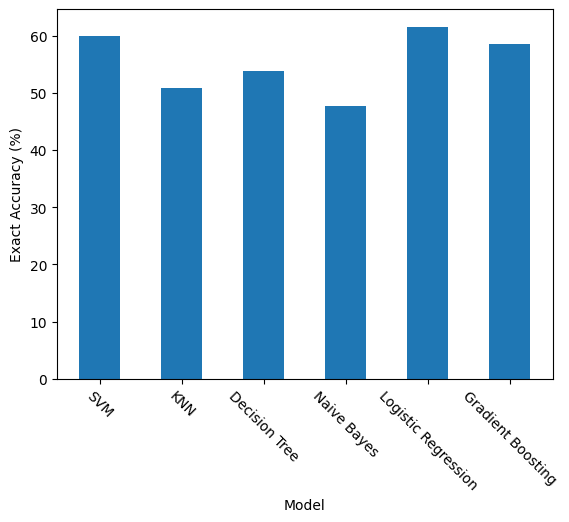

In [10]:
plt.bar(models, emg_accuracies, width=0.5)

plt.xticks(rotation=-45)
plt.xlabel('Model')
plt.ylabel('Exact Accuracy (%)')

plt.show()

## IMU Only

In [11]:
x = df.drop(columns=['volume', 'substance', 
                     'channel 1', 'channel 2', 'channel 3', 'channel 4', 'channel 5', 'channel 6', 'channel 7', 'channel 8', 
                     'channel 9', 'channel 10', 'channel 11', 'channel 12', 'channel 13', 'channel 14', 'channel 15', 'channel 16'])
y = df[['substance', 'volume']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(x_train_scaled.shape)  
print(y_train.shape)  

(258, 60)
(258, 2)


C:\Users\chloe\AppData\Local\Temp\ipykernel_19984\1897593595.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance',


In [12]:
models = []
imu_accuracies = []

model = MultiOutputClassifier(svm_model)
train_and_plot_multioutput_model(model, 'SVM', imu_accuracies, cm=False)

model = MultiOutputClassifier(knn_model)
train_and_plot_multioutput_model(model, 'KNN', imu_accuracies, cm=False)

model = MultiOutputClassifier(dt_model)
train_and_plot_multioutput_model(model, 'Decision Tree', imu_accuracies, cm=False)

model = MultiOutputClassifier(nb_model)
train_and_plot_multioutput_model(model, 'Naive Bayes', imu_accuracies, cm=False)

model = MultiOutputClassifier(regression_model)
train_and_plot_multioutput_model(model, 'Logistic Regression', imu_accuracies, cm=False)

model = MultiOutputClassifier(gb_model)
train_and_plot_multioutput_model(model, 'Gradient Boosting', imu_accuracies, cm=False)

SVM
Exact Match Accuracy: 0.8154
Average Per-Label Accuracy: 0.9077
Per-Label Accuracies: [0.92307692 0.89230769]
----------------------------
KNN
Exact Match Accuracy: 0.8462
Average Per-Label Accuracy: 0.8692
Per-Label Accuracies: [0.87692308 0.86153846]
----------------------------
Decision Tree
Exact Match Accuracy: 0.7077
Average Per-Label Accuracy: 0.8385
Per-Label Accuracies: [0.83076923 0.84615385]
----------------------------
Naive Bayes
Exact Match Accuracy: 0.6615
Average Per-Label Accuracy: 0.7769
Per-Label Accuracies: [0.78461538 0.76923077]
----------------------------
Logistic Regression
Exact Match Accuracy: 0.8462
Average Per-Label Accuracy: 0.9231
Per-Label Accuracies: [0.92307692 0.92307692]
----------------------------
Gradient Boosting
Exact Match Accuracy: 0.8462
Average Per-Label Accuracy: 0.9154
Per-Label Accuracies: [0.90769231 0.92307692]
----------------------------


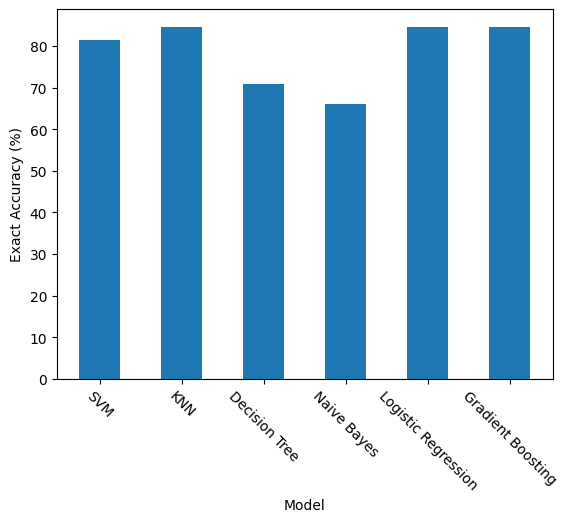

In [13]:
plt.bar(models, imu_accuracies, width=0.5)

plt.xticks(rotation=-45)
plt.xlabel('Model')
plt.ylabel('Exact Accuracy (%)')

plt.show()

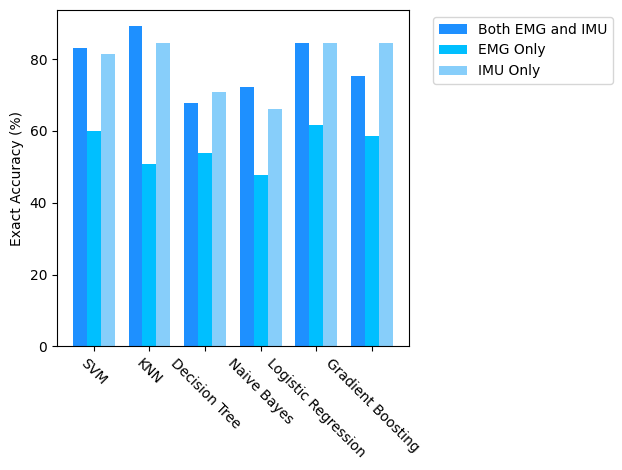

In [14]:
both_accuracies_df = pd.read_csv('multioutput_bandpass_accuracies.csv', header=None)
both_accuracies = both_accuracies_df.iloc[0].tolist()

x = np.arange(len(models))  # [0, 1, 2]
width = 0.25  # width of each bar

# Plot bars side by side
plt.bar(x - width, both_accuracies, width, label='Both EMG and IMU', color='dodgerblue')
plt.bar(x, emg_accuracies, width, label='EMG Only', color='deepskyblue')
plt.bar(x + width, imu_accuracies, width, label='IMU Only', color='lightskyblue')

# Add labels
plt.xticks(x, models, rotation=-45)
plt.ylabel('Exact Accuracy (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()